# Using the Poisson-Boltzmann solver code on a continuum system. 

## Comparing sintering temperatures

In this notebook the effect of the sintering temperature is compared for a range of temperatures for gadolinium-doped ceria using a continuum model. The continuum model differs from the site explicit model as defects are not confined to their specific sites generated using METADISE, but can occupy any position in a grid of equally spaced sites. 

The grid of equally spaced sites is created using the `form_continuum_sites` function.

Initially the defect Set_of_Sites are created and read into the function, and a grid of equally spaced sites is created using np.linspace between a minimum and maximum value defined by the user. A scaling term is calculated between the length of the original set of sites and the grid to maintain constant charge density. 
The defects in the full Set_of_Sites class are split into oxygen vacancies and gadolinium ions and are projected onto the grid, the average energies are taken at each site and the values interpolated over all of the sites in the equally spaced grid using the `scipy.interpolate.griddata` function. New Set_of_Sites classes are produced for the two sets of energies and coordinates and these are concatenated into a new Set_of_Sites class containing all of the information for both defects. The Poisson-Boltzmann code is run as usual on the new set of sites. 

```
def form_continuum_sites( all_sites, x_min, x_max, n_points, b, c, defect_species ):

    grid_1 = np.linspace( x_min, x_max, n_points )

    Gd_scaling = len( all_sites.subset( 'Ce' ) ) / len( grid_1 )
    Vo_scaling = len( all_sites.subset( 'O' ) ) / len( grid_1 )

    Vo_continuum_grid = Grid( grid_1, b, c, all_sites.subset( 'O' ) )
    Gd_continuum_grid = Grid( grid_1, b, c, all_sites.subset( 'Ce' ) )

    Vo_average_energies = np.array( [ site.average_local_energy( method = 'mean' )[0] for site in all_sites.subset( 'O' ) ] )
    Gd_average_energies = np.array( [ site.average_local_energy( method = 'mean' )[0] for site in all_sites.subset( 'Ce' ) ] )


    Vo_new_energies = griddata( ( [ site.x for site in all_sites.subset( 'O' ) ] ), Vo_average_energies, grid_1, method = 'nearest' )
    Gd_new_energies = griddata( ( [ site.x for site in all_sites.subset( 'Ce' ) ] ), Gd_average_energies, grid_1, method = 'nearest' )


    Vo_new_sites = Set_of_Sites( [ Site( 'O', x, [ defect_species['Vo'] ], [e], scaling = np.array( Vo_scaling ) ) for x, e in zip( grid_1, Vo_new_energies ) ] )
    Gd_new_sites = Set_of_Sites( [ Site( 'Ce', x, [ defect_species['Gd'] ], [e], scaling = np.array( Gd_scaling ) ) for x, e in zip( grid_1, Gd_new_energies ) ] )

    all_sites_new = Vo_new_sites + Gd_new_sites

    return all_sites_new
```

The Poisson-Boltzmann code is run at a high temperature with both gadolinium ions and oxygen vacancies able to redistribute and then the gadolinium ions are fixed to the high temperature distrobution and the Poisson-Boltzmann code is rerun at a typical operating temperature allowing only the oxygen vacancies to redistribute. The grain boundary potential, charge density, defect distributions and resistivities are calculated.

In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [2]:
data = '/Users/glw33/ipython_notebooks/Gd_Ce02_space_charge_systems/Input_Data/Gd_CeO2_111_data.txt'

### Sintering temperatures.

The calculation loops over a range of different sintering temperatures followed by running at one 'operating' temperature to allow the comparison between sintering temperature and resistivity.

``` temp_sinter = [1173.15, 1273.15, 1373.15, 1473.15, 1573.15, 1673.15, 1773.15, 1873.15, 1973.15] ```

In [3]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.136e-9
grid_x_max = +6.022e-9
bulk_region_x_min = 1.4e-8 
bulk_region_x_max = 1.8e-8

n_points = 1000

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp_sinter = [1173.15, 1273.15, 1373.15, 1473.15, 1573.15, 1673.15, 1773.15, 1873.15, 1973.15]

valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.01, 0.04 ], [ 0.0125, 0.05 ], [ 0.025, 0.1 ], [ 0.0375, 0.15 ], [ 0.05, 0.2 ], [ 0.0625, 0.25 ], [ 0.075, 0.3 ], [ 0.0875, 0.35 ] ])

### Output defect mole fractions.

When the calculation is run on this real system, the bulk mole fraction of each defect species in the output is less than the desired bulk mole fraction for each defect, therefore a correction is required to ensure that that bulk mole fraction of each defect in the output is what it should be. 
To achieve this, an array of 8 different mole fractions between [0.01, 0.04] and [0.0875, 0.35] (as defined above) are used as the input for the calculation at each temperature and a `bulk_region_x_min` and a `bulk_region_x_max` selected so there is no grain boundary effects. Once the calculation has been completed for each of the mole fractions at a given temperture, a linear regression is performed on the input mole fraction against the output mole fraction. Once the slope and intercept has been obtained the mole fraction required as input to give the desired mole fraction as output can be calculated. This is done for each temperature and the results stored in an array called mole fractions (overwriting the original array).

In [4]:
# Empty lists are created to store the slope and intercept from the linear regression.
slope_list = []
intercept_list = []

# fixed refers to whether the immobile defect is to be fixed to its bulk mole fraction.
fixed = False

# Loops over temperature.
for t in temp_sinter:
    # Creates an empty list to store the uncorrected output mole fractions.
    avg_Vo_molfracs = []
    # Loops over input mole fractions. 
    for m in mole_fractions:
        # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
        defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
        data_file = open( data, 'r')
        # Each line in the input data file is read and split into individual strings.
        # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
        # is within the range defined. These sites are then compiled into a list 'all_sites'
        input_data = [ line.split() for line in data_file.readlines() ]
        input_data = [ line for line in input_data if ( float(line[1]) > bulk_region_x_min and float(line[1]) < bulk_region_x_max ) ] 
        all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
        new_sites = form_continuum_sites( all_sites, bulk_region_x_min, bulk_region_x_max, n_points, b, c, defect_species )
        # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
        for site in new_sites.subset( 'Ce' ):
            site.defect_with_label('Gd').fixed = False
        # Runs the Poisson-Boltzmann solver and returns the output mole fraction. 
        avg_Vo_MF = calculate_average_molefraction( t, bulk_region_x_min, bulk_region_x_max, b, c, index, alpha, conv, new_sites, site_labels, 'dirichlet')
        avg_Vo_molfracs.append( avg_Vo_MF ) 
    # the linear regression is performed on the input and output mole fractions. 
    slope, intercept, rvalue, pvalue, stderr = stats.linregress( mole_fractions[:,0], avg_Vo_molfracs )
    slope_list.append( slope )
    intercept_list.append( intercept )

# The percentage gadolinium content is defined here and is converted into a desired mole fraction for the 'real' calculation.
percentage_Gd = 10
desired_mobile_defect_MF = ( percentage_Gd / 100 ) / 4
# The input mole fractions that will give the desired output mole fractions for the given percentage gadolinium content are calculated from the linear regreassion results.
# This is done for each temperature and is compiled into an array overwriting the original mole_fractions array.
mole_fractions = np.array( [ MF( desired_mobile_defect_MF, s, i ) for s, i in zip( slope_list, intercept_list ) ] )

### Running the calculation.

The calculation loops over each of the sintering temperature values. 
`fixed = False` to allow both the gadolinium ions and the oxygen vacancies to redistribute while the calculation is run. The potential, charge density and defect distributions are plotted.

The gadolinium ions are then fixed to the sintering temperature distribution.

```    for site in new_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').fixed = False ```
        
Followed by the calculation being rerun at a typical solid oxide fuel cell operating temperature (773.15 K). 
The potential, charge denisty and defect distributions are plotted again and the resistivity and space charge widths are calculated for the system at 773.15 K.

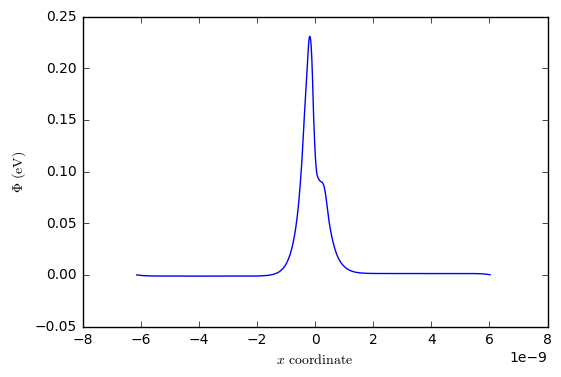

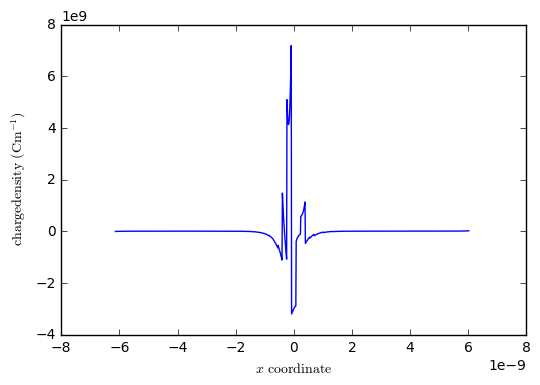

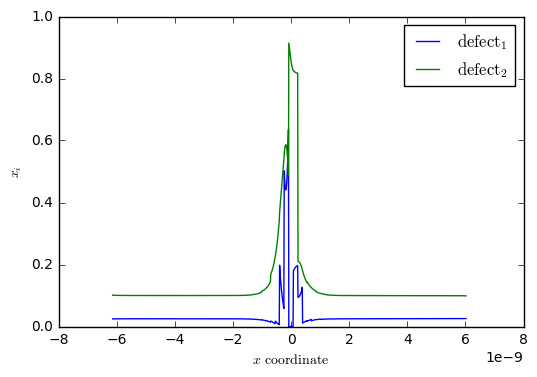

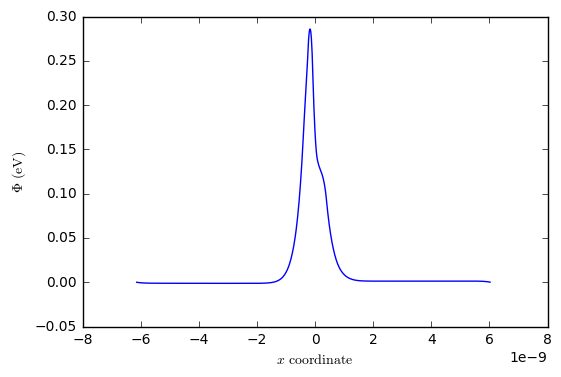

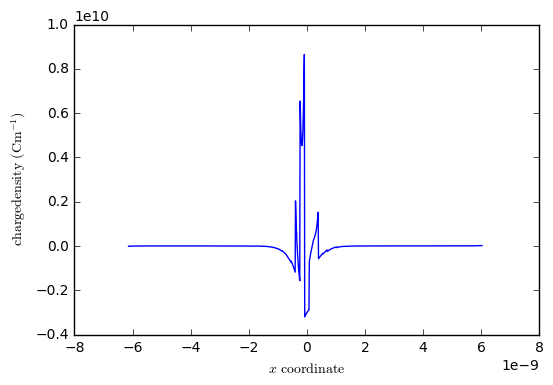

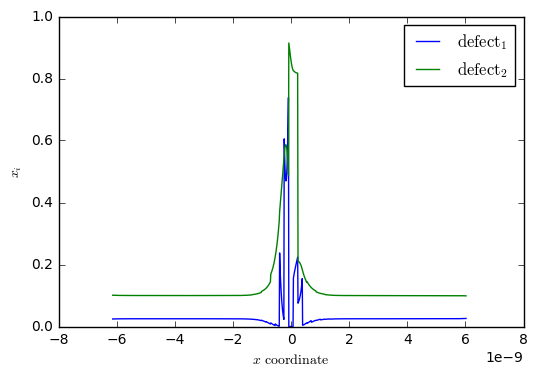

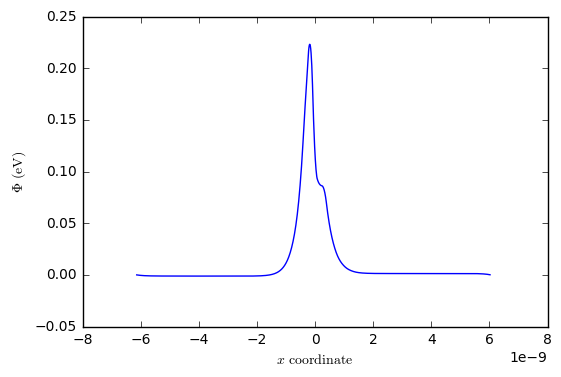

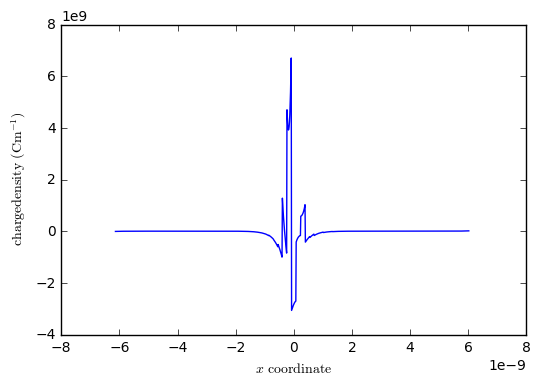

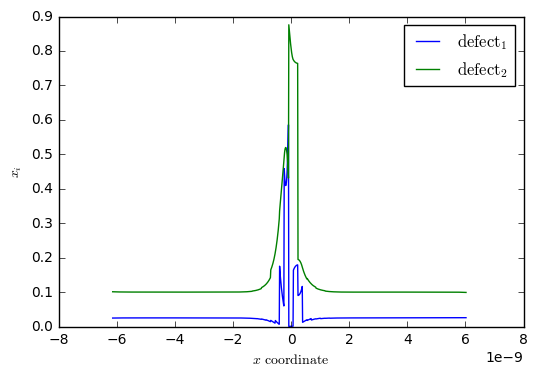

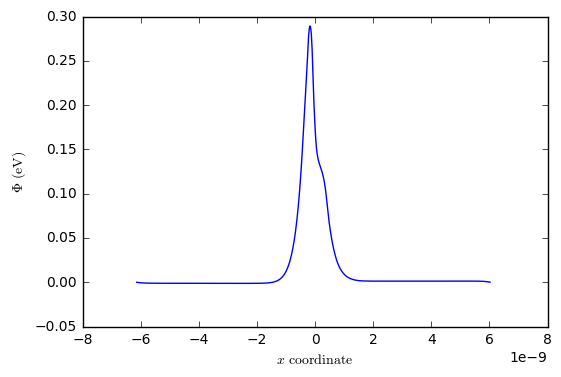

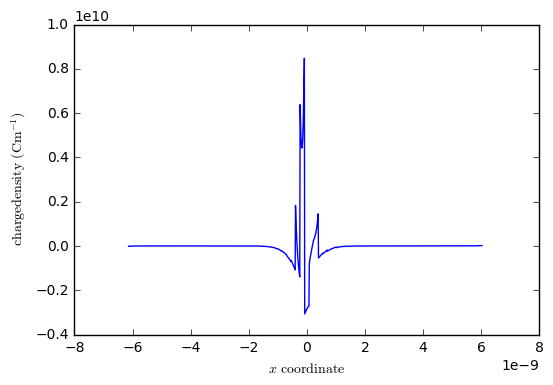

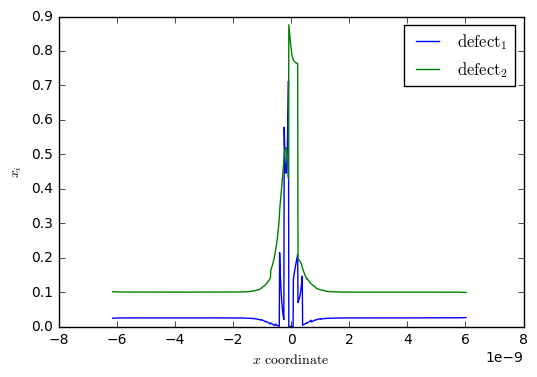

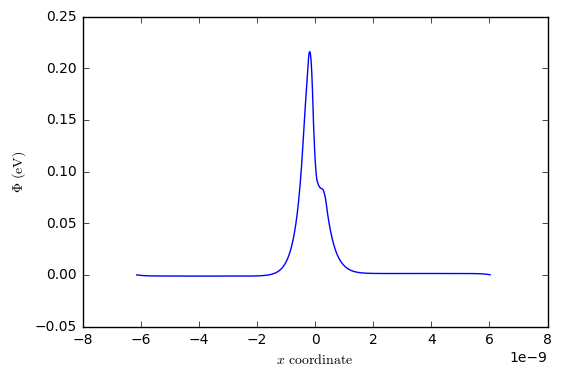

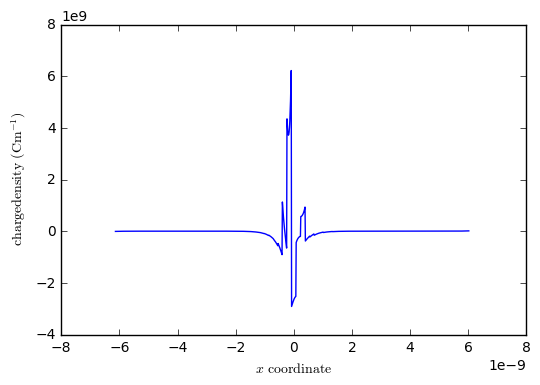

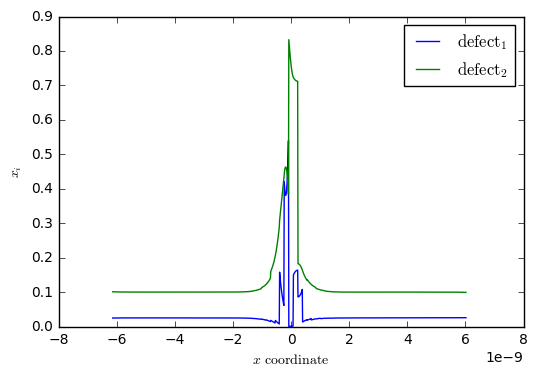

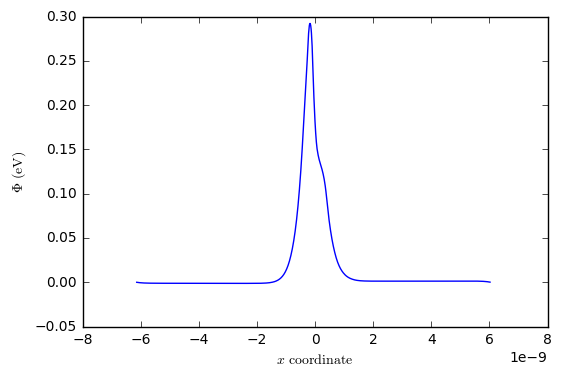

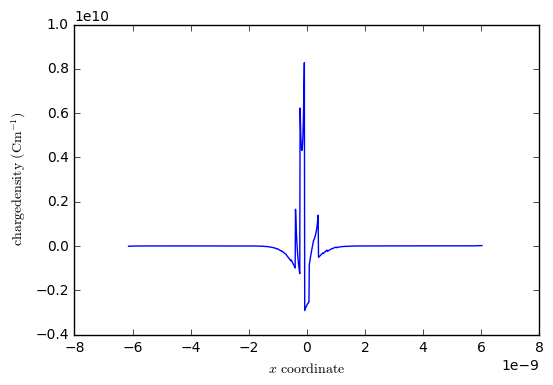

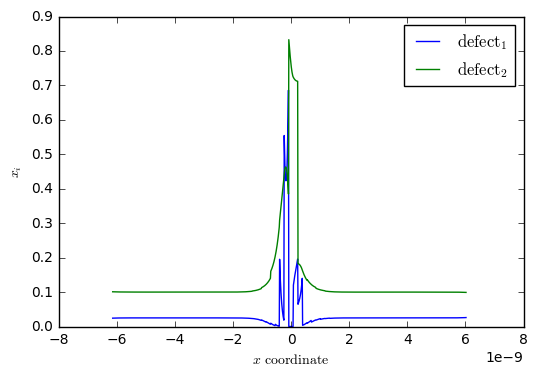

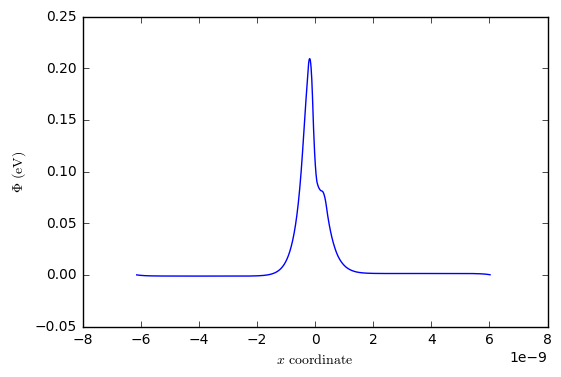

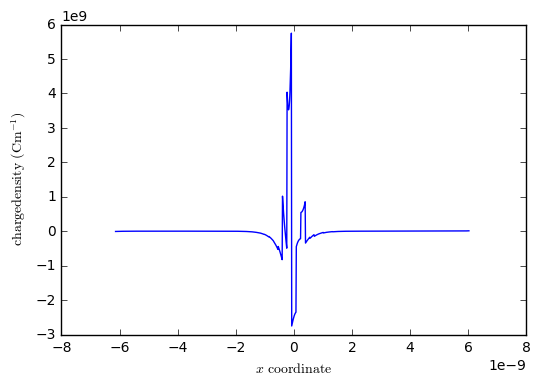

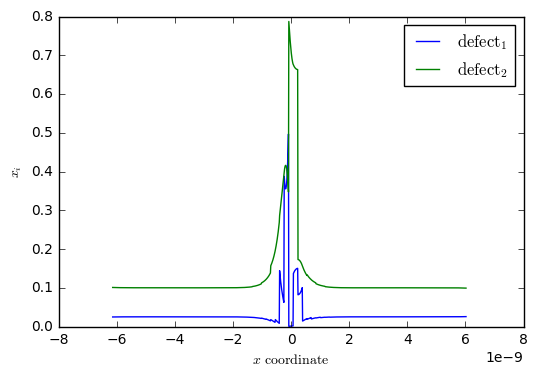

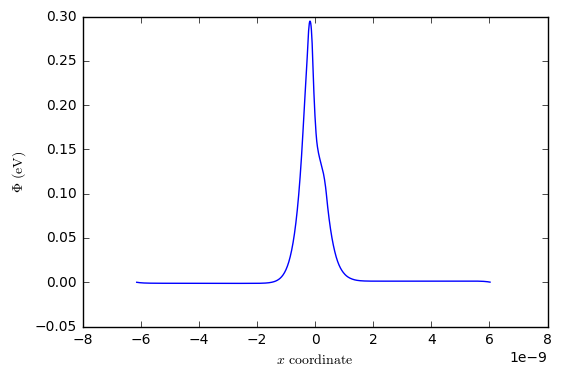

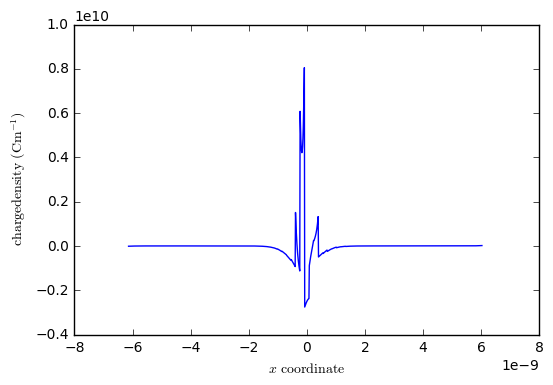

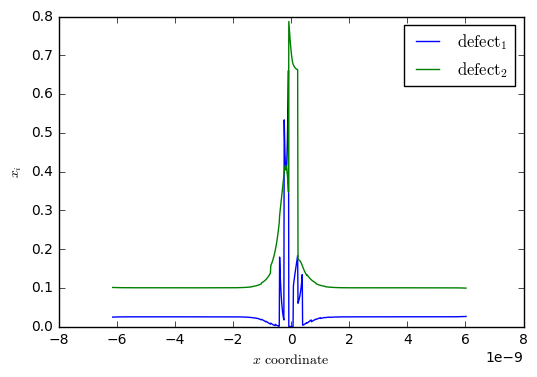

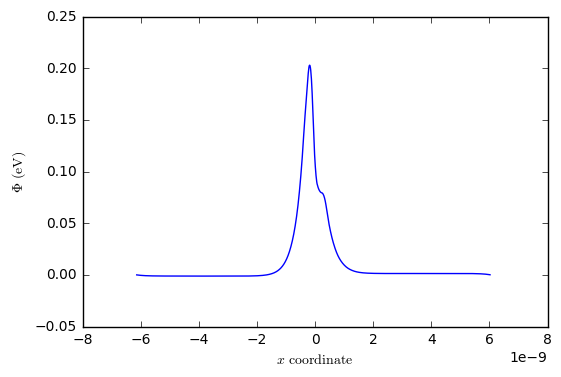

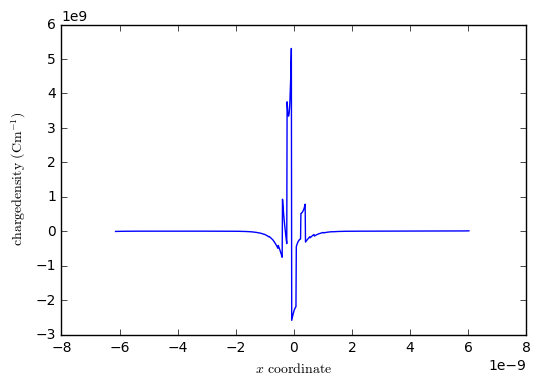

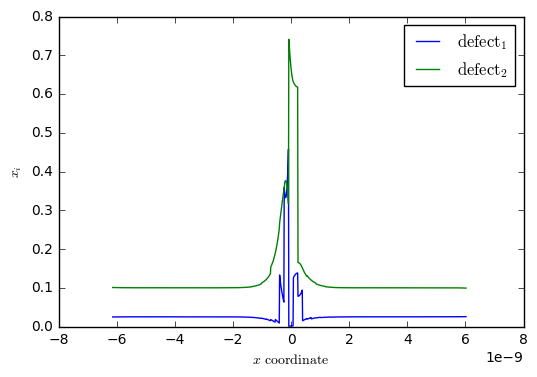

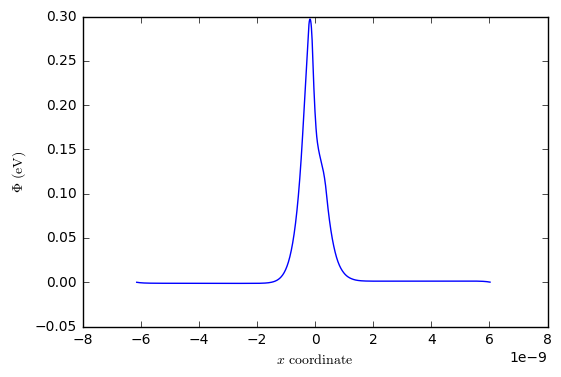

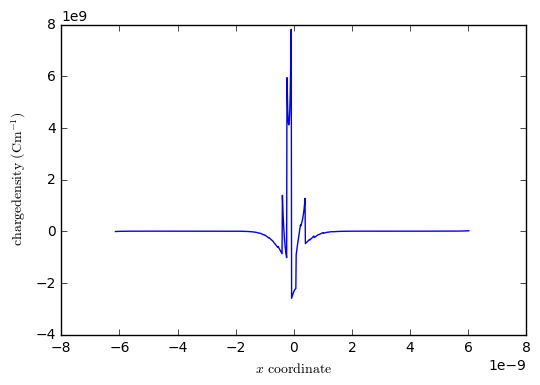

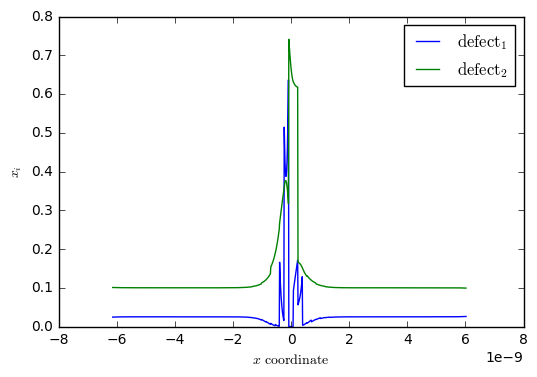

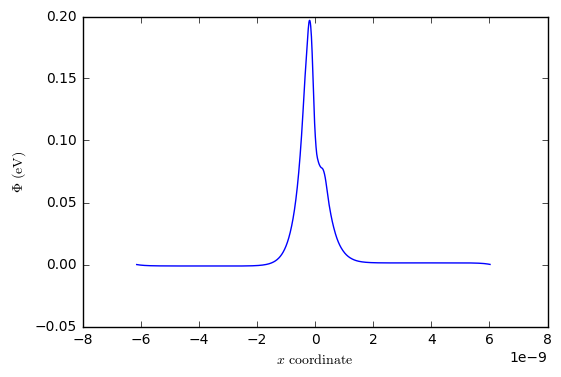

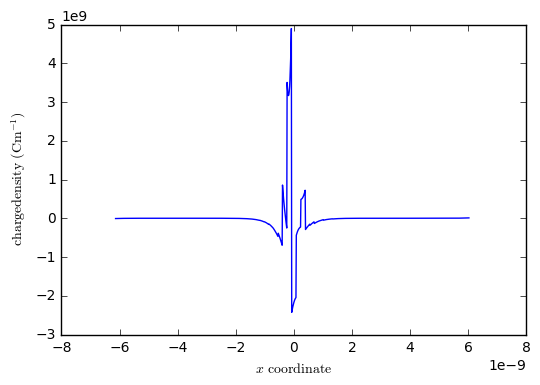

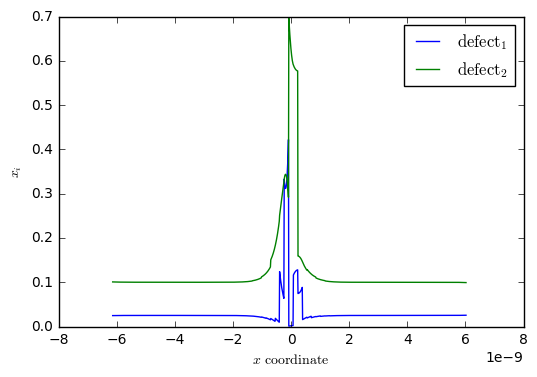

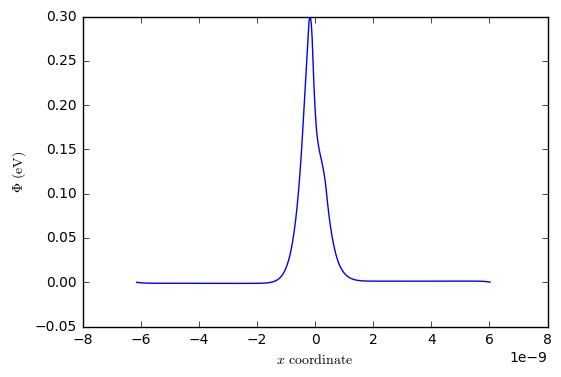

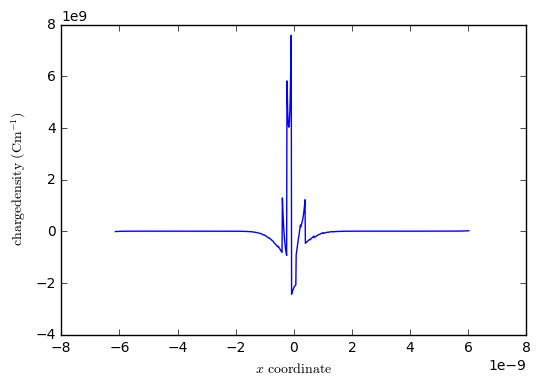

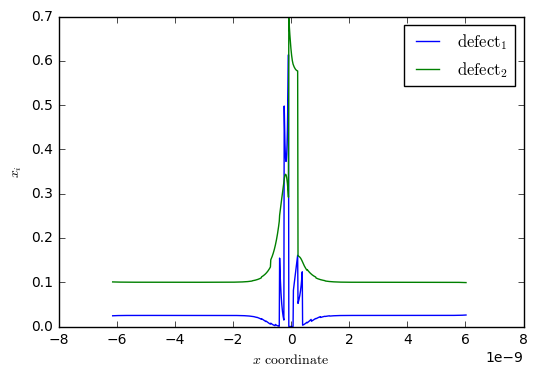

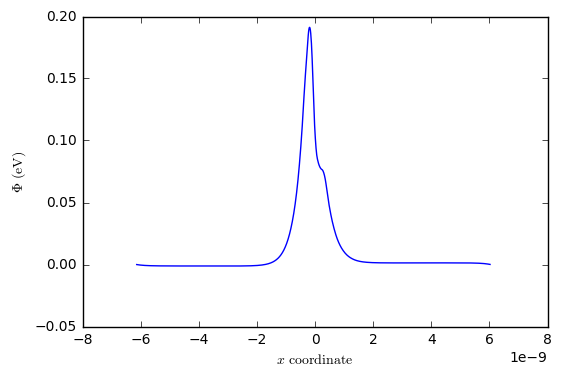

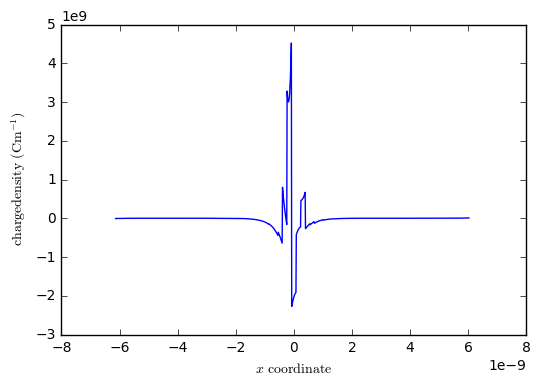

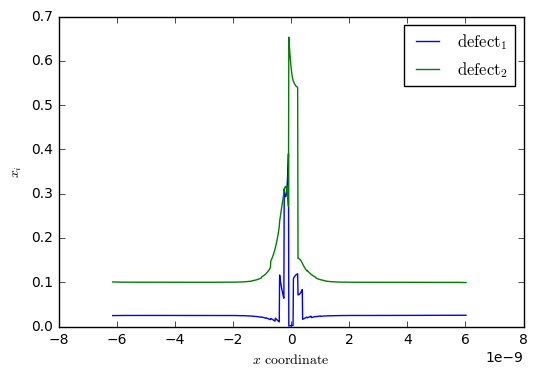

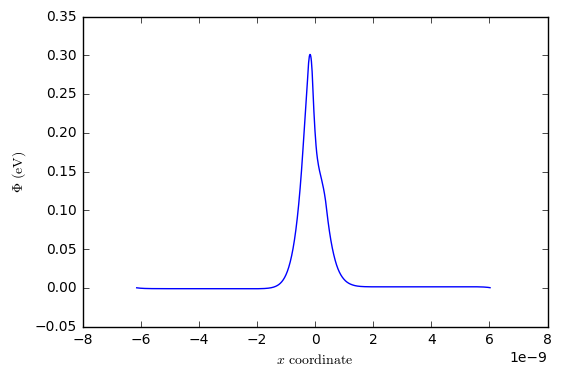

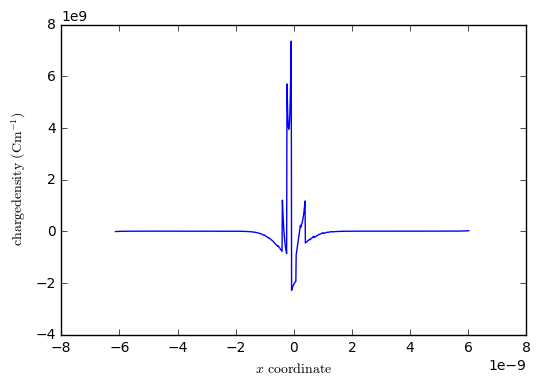

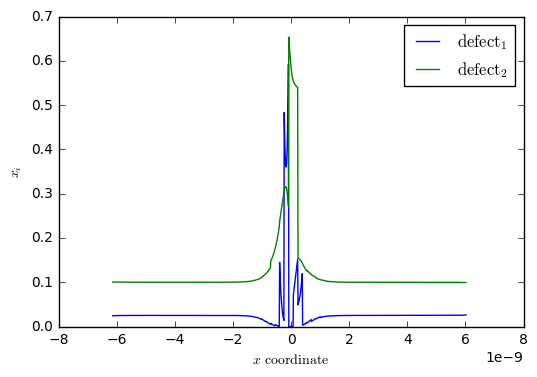

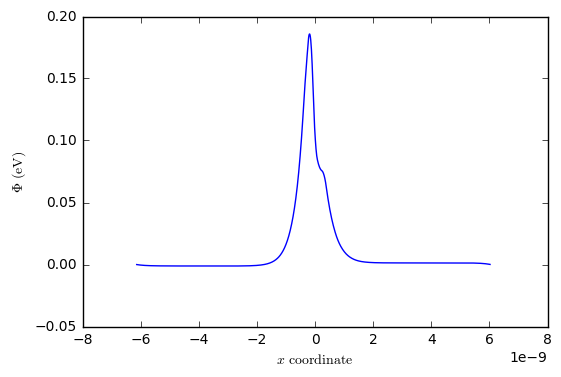

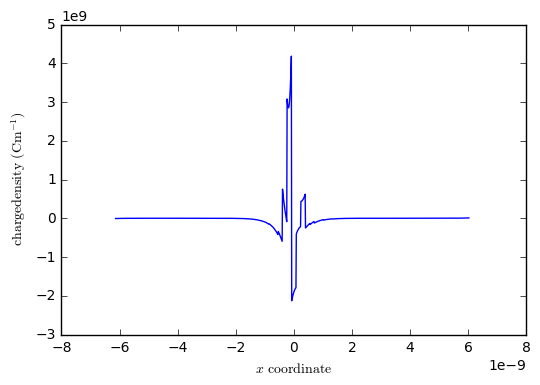

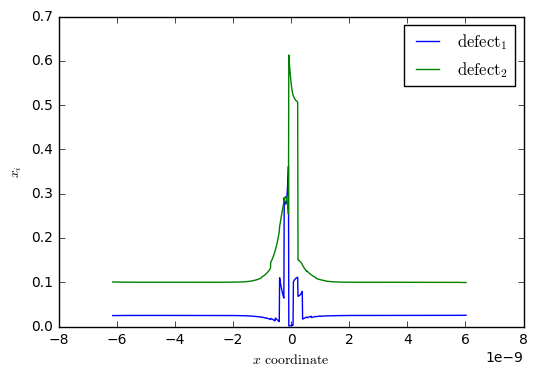

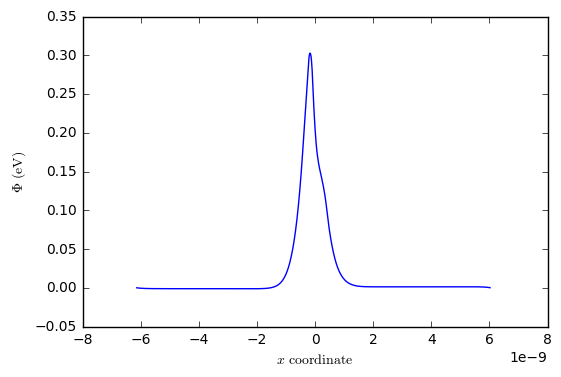

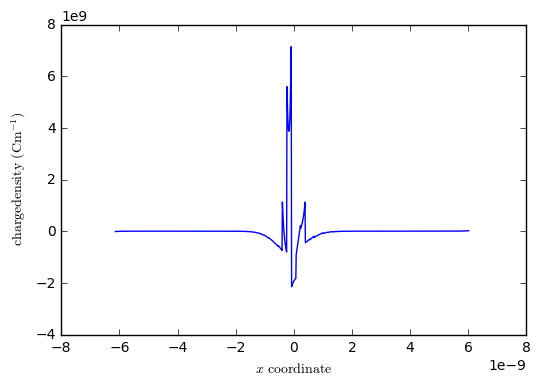

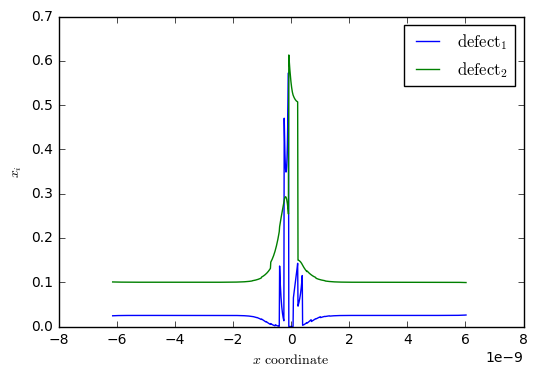

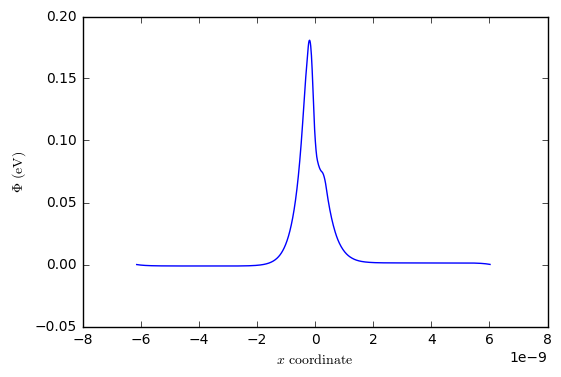

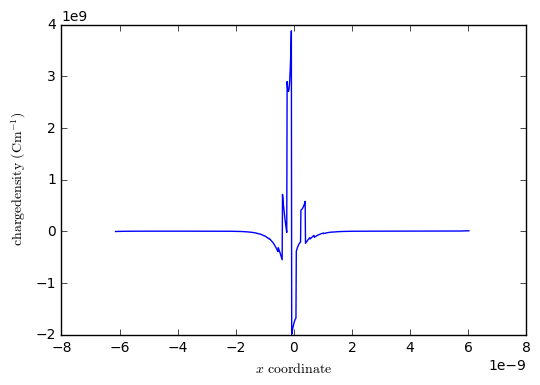

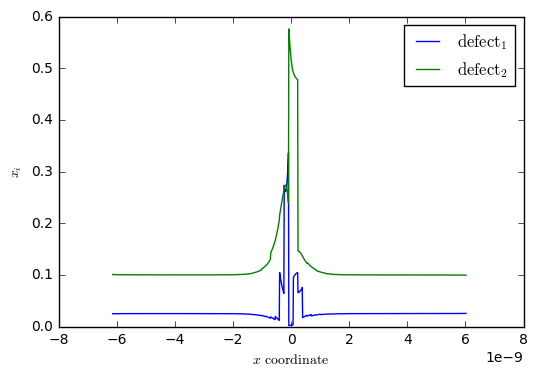

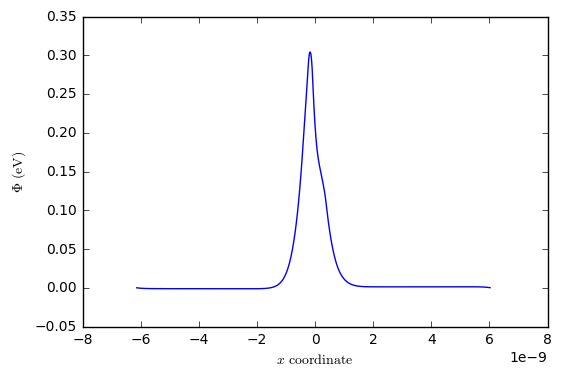

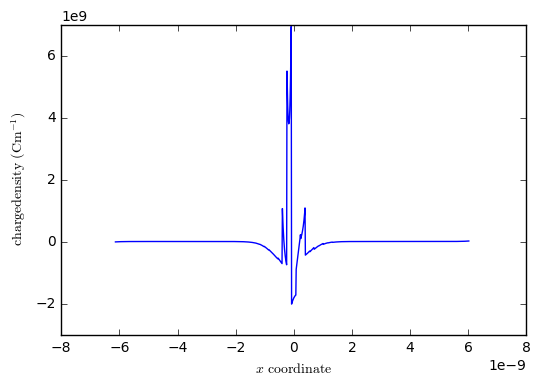

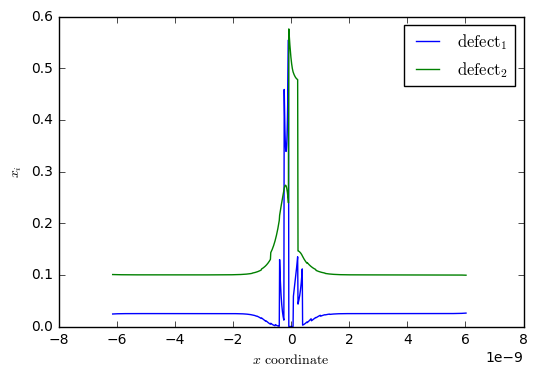

In [5]:
# Empty lists are created to store the calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature.
ratios = []
bulk_density_list = []
max_phi_list = []
ratios_2 = []
bulk_density_list_2 = []
max_phi_list_2 = []

# Each temperature and its corresponding input mole fraction are zipped together. These are then looped over for each calculation.
for t, m in zip( temp_sinter, mole_fractions ):
    fixed = False
    # From the system specific constants a defect species is produced by zipping together the defect label, valence and mole fraction for each species.
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    data_file = open( data, 'r')
    # Each line in the input data file is read and split into individual strings.
    # These individual strings are then created into sites providing the second element on each line ( the x coordinate)
    # is within the range of values either side of the grain boundary defined. These sites are then compiled into a list 'all_sites'
    input_data = [ line.split() for line in data_file.readlines() ]
    input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
    all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
    new_sites = form_continuum_sites( all_sites, grid_x_min, grid_x_max, n_points, b, c, defect_species )
    # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
    for site in new_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').fixed = False
    # The Poisson-Boltzmann solver is run and returns the site explicit properties.
    # These properties are stacked into a table and saved in a .dat file.
    grid, phi, rho, probabilities, resistivity_ratio, Vo_mole_fraction, Gd_mole_fraction, bulk_density, niter = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_MF, new_sites, site_labels, 'dirichlet'  )
    site_data = np.column_stack( ( grid.x, phi, rho, probabilities, Vo_mole_fraction, Gd_mole_fraction ) )
    site_data_filename = '{}_GC_continuum_sintering_site_data_percentGd{}_temp{}_bulkfixed{}.dat'.format( index, percentage_Gd, t, fixed )
    header = ' x, phi, rho, probabilities, Vo_MF, Gd_MF, temp, Gd_fixed_to_bulk '
    np.savetxt( site_data_filename, site_data, header = header )
    # The calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature are stored in the defined lists.
    ratios.append( resistivity_ratio )   
    bulk_density_list.append( bulk_density )
    max_phi_list.append( max(phi) )
    
    plt.plot(grid.x, phi)
    plt.xlabel( '$x$ $\mathrm{coordinate}$' )
    plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
    plt.show()

    plt.plot(grid.x, rho)
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
    plt.show()

    plt.plot(grid.x, Vo_mole_fraction, label = '$\mathrm{defect_1}$')
    plt.plot(grid.x, Gd_mole_fraction, label = '$\mathrm{defect_2}$')
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel('$x_{i}$')
    plt.legend()
    plt.show()

    # Empty lists are created to store the calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature.

    # This fixes the immobile defect to its bulk mole fraction throughout the calculation. Assuming Mott-Schottky conditions.
    fixed = True
    for site in new_sites.subset( 'Ce' ):
        site.defect_with_label('Gd').mole_fraction = site.probabilities( phi_at_x( phi, grid.x, site.x ), t )[0]
        site.defect_with_label('Gd').fixed = fixed
    temp = 773.15
    # The Poisson-Boltzmann solver is run and returns the site explicit properties.
    # These properties are stacked into a table and saved in a .dat file.
    grid, phi, rho, probabilities, resistivity_ratio, Vo_mole_fraction, Gd_mole_fraction, bulk_density, niter = calculate_GB_properties( temp, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_MF, new_sites, site_labels, 'dirichlet'  )
    site_data = np.column_stack( ( grid.x, phi, rho, probabilities, Vo_mole_fraction, Gd_mole_fraction ) )
    site_data_filename = '{}_continuum_sintering_part_two_site_data_percentGd{}_temp{}_sintertemp{}_bulkfixed{}.dat'.format( index, percentage_Gd, temp, t, fixed )
    header = ' x, phi, rho, probabilities, Vo_MF, Gd_MF, temp, Gd_fixed_to_bulk '
    np.savetxt( site_data_filename, site_data, header = header )
    # The calculated resistivity ratio, the defect density in the bulk and the space charge potential for each temperature are stored in the defined lists.
    ratios_2.append( resistivity_ratio )   
    bulk_density_list_2.append( bulk_density )
    max_phi_list_2.append( max(phi) )

    plt.plot(grid.x, phi)
    plt.xlabel( '$x$ $\mathrm{coordinate}$' )
    plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
    plt.show()

    plt.plot(grid.x, rho)
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
    plt.show()

    plt.plot(grid.x, Vo_mole_fraction, label = '$\mathrm{defect_1}$')
    plt.plot(grid.x, Gd_mole_fraction, label = '$\mathrm{defect_2}$')
    plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
    plt.ylabel('$x_{i}$')
    plt.legend()
    plt.show()
    
temp = [773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15, 773.15 ]
# Once the site explicit properties, and resistivity ratio have been calculated, the additional grain boundary properties can be calculated.

# The ionic conductivity activation energy
#Ea = calculate_activation_energy( ratios_2, temp ) 

# The space charge potential calculated using the Mott-Schottky approximation.
MS_phi = np.array( [ float(solve_MS_for_phi(r, t, valence[0])) for r, t in zip( ratios_2, temp ) ] )

# The space charge width.
SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, max_phi_list_2, bulk_density_list_2 ) ] )

# And the space charge width calculated from the Mott-Schottky space charge potential.
MS_SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, MS_phi, bulk_density_list_2 ) ] )


In [9]:
# The grain boundary properties are put together in a pandas DataFrame and stored as a .csv file.

filename = 'continuum_sintering_GB_propertiespercentGd{}.csv'.format( percentage_Gd )
data = pd.DataFrame( np.column_stack( ( temp[1:-1], max_phi_list[1:-1], ratios[1:-1], MS_phi[1:-1], SCW[1:-1], MS_SCW[1:-1] ) ),
       columns = [ 'temp', 'phi_0', 'r_gb', 'phi_0_MS', 'space_charge_width', 'MS_space_charge_width'] )
data['GB'] = index
data['Gd%'] = percentage_Gd
data['sintering_temp'] = temp_sinter[1:-1]
print(data)
data.to_csv( filename, index = False )

     temp     phi_0      r_gb  phi_0_MS  space_charge_width  \
0  773.15  0.223102  1.688128  0.227674            2.501724   
1  773.15  0.215956  1.476163  0.233579            2.514483   
2  773.15  0.209239  1.349232  0.239197            2.525746   
3  773.15  0.202907  1.267549  0.244467            2.535681   
4  773.15  0.196924  1.211886  0.249364            2.544459   
5  773.15  0.191265  1.172175  0.253885            2.552236   
6  773.15  0.185906  1.142767  0.258042            2.559150   

   MS_space_charge_width   GB  Gd%  sintering_temp  
0               2.219510  111   10         1273.15  
1               2.248110  111   10         1373.15  
2               2.274983  111   10         1473.15  
3               2.299909  111   10         1573.15  
4               2.322831  111   10         1673.15  
5               2.343794  111   10         1773.15  
6               2.362901  111   10         1873.15  


### Results

As with the site explicit model, it can be seen from the results above that the grain boundary resistivity decreases as sintering temperature increases which disagrees with the experimental prediction. One potential reason for this is that on an experimental timescale, the gadolinium ions may not redistribute to thir equilibirum positions as they do in this model due to having a low mobility. The difference between the results for the site explicit and continuum models are negligable in this case with a difference of approximated 0.01 eV between the space charge potential between the models. This is because the continuum sites still has all of the information regarding favourable defect positions which has been interpolated across the region. This difference could be more significant if using a conventional continuum model where only the grain boundary segregation energy is considered. 